## Loading in mnist data

In [20]:
import pandas as pd

# Download train/val data
print("Downloading training/validation dataset... ", end='')
trainval_df = pd.read_csv("https://ashwhall.github.io/download/mnist_csv/mnist_train.zip", header=None)
print("done.")

# Download test data
print("Downloading training/validation dataset... ", end='')
test_df = pd.read_csv("https://ashwhall.github.io/download/mnist_csv/mnist_test.zip", header=None)
print("done.")

In [21]:
# Sample the train examples
train_df = trainval_df.sample(frac=0.8, random_state=42)
# Use 'drop' to take what's left
val_df = trainval_df.drop(train_df.index)

print("Train DataFrame:     ", train_df.shape)
print("Validation DataFrame:", val_df.shape)
print("Test DataFrame:      ", test_df.shape)

Train DataFrame:      (48000, 785)
Validation DataFrame: (12000, 785)
Test DataFrame:       (10000, 785)


In [22]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
12628,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37730,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39991,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8525,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8279,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
import numpy as np

# A utility function to extract the labels and images from a dataframe
def extract_images_labels(df):
    # Extract the first column values as labels
    labels = np.array(df.iloc[:, 0])

    # Extract the remaining columns as images
    images = np.array(df.iloc[:, 1:])

    # Reshape the images and convert to floats
    images = images.reshape(-1, 28, 28, 1).astype(np.float32)

    return images, labels

# Perform the extraction on each of the DataFrames
train_images, train_labels = extract_images_labels(train_df)
val_images, val_labels = extract_images_labels(val_df)
test_images, test_labels = extract_images_labels(test_df)

print("Train image shape:", train_images.shape)

Train image shape: (48000, 28, 28, 1)


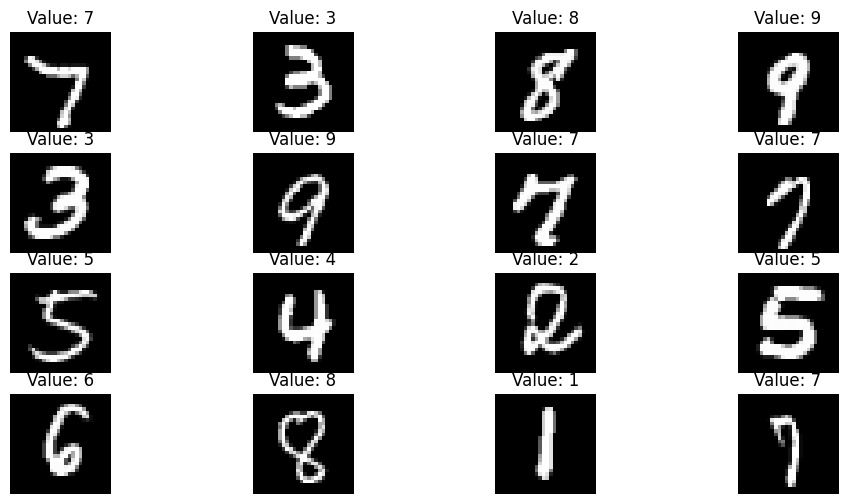

In [24]:
# Import a graph-plotting library
import matplotlib.pyplot as plt

# This function takes a list of images and a list of labels and plots the first n_images
def plot_some_images(images, labels, n_images=16):
    # Set the figure size
    plt.figure(figsize=(12, 6))

    for i in range(n_images):
        # Select a subplot in a grid
        plt.subplot(4, 4, i + 1)
        img = images[i]
        # Select the channel dimension, depending on data format
        img = img[0] if img.shape[0] == 1 else img[..., 0]

        # Plot the image with title and no axis ticks
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.title(f"Value: {labels[i]}")
        plt.axis('off')
    plt.show()

# Plot some training images and labels - feel free to display the validation and
# test images instead
plot_some_images(train_images, train_labels)

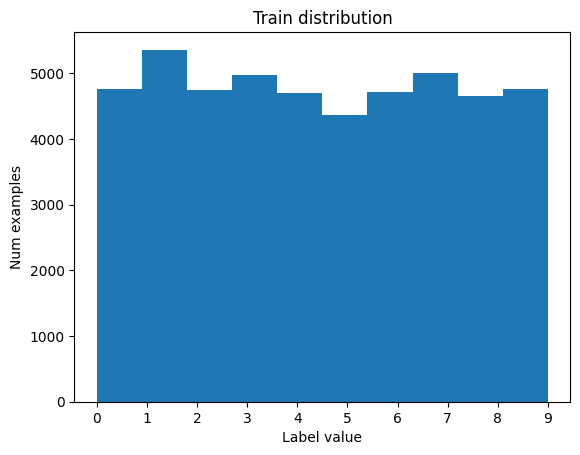

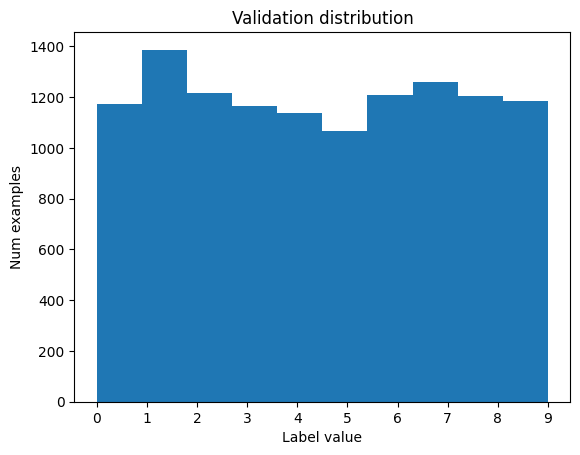

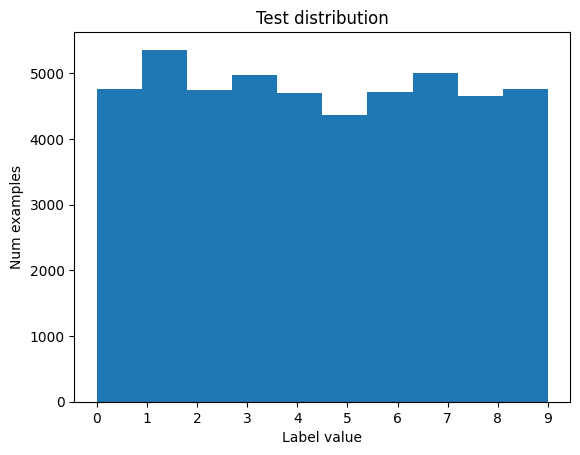

In [25]:
def plot_label_distribution(labels, split):
    # Plot a histogram with the given title
    plt.title(f"{split} distribution")
    plt.hist(labels, bins=10)
    # Label the axes
    plt.xlabel("Label value")
    plt.ylabel("Num examples")
    # Add the class labels along the x axis
    plt.xticks(range(10))
    plt.show()

# Plot the distribution of each partition
plot_label_distribution(train_labels, "Train")
plot_label_distribution(val_labels, "Validation")
plot_label_distribution(train_labels, "Test")

In [29]:
# Dataset class
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class MNISTDataset(Dataset):

    def __init__(self, images, labels):
        # TODO: Store the images and labels as member variables
        #       self.images and self.labels respectively.
        self.images = images
        self.labels = labels


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        label = self.labels[idx]


        return image, label
    

# prepare datasets and loaders
train_dataset = MNISTDataset(train_images,
                             train_labels)
val_dataset = MNISTDataset(val_images,
                             val_labels)
test_dataset = MNISTDataset(test_images,
                             test_labels)


train_dataset = MNISTDataset(train_images,
                             train_labels)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# transpose for training
for batch in train_loader:
  images, labels = batch
  images = images.permute(0,3,1,2)
  print("images shape: ", images.shape)
  break


images shape:  torch.Size([64, 1, 28, 28])


## Training Time

In [33]:
import torch
# By default we'll assume that GPU acceleration isn't available
device = torch.device("cpu")

# Check if GPU acceleration is available (requires a CUDA-compatible GPU) and
# set the device variable accordingly. If the computer has more than one GPU,
# you can specify which one by replacing 0 with a different index
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)

print("Training on", device)

Training on cpu


Basic Model to get started

In [34]:
import torch.nn as nn

# Custom models need to subclass nn.Module
class MLP(nn.Module):
    def __init__(self,
                 device,
                 input_size=1*28*28, # default to num_channels * height * width
                 output_size=10      # default to the number of classes
                 ):
        super().__init__()

        # Write the classifier layers here.
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)

        )
        # Transfer the model weights to the GPU
        self.to(device)

    def forward(self, x):
        return self.seq(x)

Main training loop

In [ ]:
# tqdm can be used to print a nice progress bar during training
from tqdm.notebook import tqdm
from datetime import datetime
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

# TODO: change exp_name whenever you try a different model or change
#       something in your model. It is used for tensorboard logging.
exp_name = "MLP version 1"

# The SummaryWriter requires a directory path to write logs. We will construct a
# string using the exp_name and a date attached to the end. This way if we run the
# same experiment twice it will be listed separate on tensorboard.
log_name = "logs/" + exp_name + f" {datetime.now()}"
print("Tensorboard logs will be written to:", log_name)
writer = SummaryWriter(log_name)

criterion = nn.CrossEntropyLoss()

# Use MLP as the model
model = DeepConvNet(device)

# Use the Adam optimizer with initial learning rate set to 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#initialize metric
train_accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes = 10).to(device)
val_accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes = 10).to(device)

# The number of times we loop over the entire dataset
num_epochs = 10

for epoch in tqdm(range(num_epochs)):

    # The following is computed for every complete pass through the dataset
    epoch_train_loss = 0.0
    epoch_accuracy = 0.0

    for data in train_loader:

        images, labels = data
        images, labels = images.to(device), labels.to(device)

        #TODO: take the permute code you wrote in one of the early cells and use
        #      it here to permute the images tensor so that it has the right shape of [64, 1, 28, 28]
        images = images.permute(0,3,1,2)


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(images)

        # Compute the loss using the loss function
        loss = criterion(outputs, labels)
        epoch_train_loss += loss.item()

        # Perform backprop using the loss
        loss.backward()
        optimizer.step()

        # Calculate accuracy for this batch
        acc = train_accuracy(outputs, labels)

    # adds the training loss and accuracy to tensorboard
    writer.add_scalar("Loss/training", epoch_train_loss, epoch)
    writer.add_scalar("Accuracy/training", train_accuracy.compute(), epoch)

    # print training statistics
    print('epoch: %d loss: %.3f' % (epoch + 1, epoch_train_loss / len(train_loader)))
    print('epoch: %d accuracy: %.3f' % (epoch + 1, train_accuracy.compute()))

    # reset for the next epoch
    train_accuracy.reset()
    # The code below computes the validation results
    for data in val_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          # TODO: need to put the permute function call here too.
          images = images.permute(0,3,1,2)
          # Put the model into eval mode and disable gradient calculations
          model.eval()
          with torch.no_grad():
              # Perform inference on the current batch of inputs
              outputs = model(images)

          acc = val_accuracy(outputs, labels)
    # adds the validation accuracy to tensorboard
    writer.add_scalar("Accuracy/validation", val_accuracy.compute(), epoch)
    # reset for the next epoch
    val_accuracy.reset()

print("finished training")
test_accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes = 10).to(device)
test_inputs = []
test_predictions = []
test_targets = []
# We can compute the final test accuracy here
for data in test_loader:
  images, labels = data
  images, labels = images.to(device), labels.to(device)

  test_inputs.extend(images.detach().cpu().numpy())
  test_targets.extend(labels.detach().cpu().numpy())

  # TODO: need to put the permute function call here too.
  images = images.permute(0,3,1,2)

  # Put the model into eval mode and disable gradient calculations
  model.eval()
  with torch.no_grad():
      # Perform inference on the current batch of inputs
      outputs = model(images)
      test_predictions.extend(outputs.detach().cpu().numpy())

  acc = test_accuracy(outputs, labels)

# Convert class prediction scores to the digits they correspond
test_predictions = np.argmax(test_predictions, 1)
test_inputs = np.array(test_inputs)
print("The final test accuracy is: ", test_accuracy.compute())

# reset internal state to make the metric ready for new data
test_accuracy.reset()


Tensorboard logs will be written to: logs/MLP version 1 2025-04-03 16:12:14.008085


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 loss: 2.754
epoch: 1 accuracy: 0.516
epoch: 2 loss: 0.816
epoch: 2 accuracy: 0.788
epoch: 3 loss: 0.542
epoch: 3 accuracy: 0.859
epoch: 4 loss: 0.394
epoch: 4 accuracy: 0.894
epoch: 5 loss: 0.321
epoch: 5 accuracy: 0.912
epoch: 6 loss: 0.274
epoch: 6 accuracy: 0.924
epoch: 7 loss: 0.240
epoch: 7 accuracy: 0.932
epoch: 8 loss: 0.212
epoch: 8 accuracy: 0.939
epoch: 9 loss: 0.191
epoch: 9 accuracy: 0.945
epoch: 10 loss: 0.172
epoch: 10 accuracy: 0.949
finished training
The final test accuracy is:  tensor(0.9380)


Deeper model

In [38]:
class DeepConvNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        # TODO 1: Initialise a Sequential module
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,8,3, padding=0),
            nn.ReLU(),
            nn.Conv2d(8,16,3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2))

        # TODO 2: Initialise an MLP module
        self.mlp = MLP(device, input_size = 32*5*5, output_size=10)

        # Transfer the model weights to the GPU
        self.to(device)

    def forward(self, x):
      
        features = self.feature_extractor(x)
        return self.mlp(features)
